In [1]:
%cd
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Colab Notebooks/diploma_thesis
%ls

/root
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/diploma_thesis
bbox_full_train.csv          imagenet/
bbox_part_train.csv          NOTEBOOK_TRANSCAM/
Conformer_small_patch16.pth  plot_images_for_thesis.ipynb
CutLER/                      plot_presentation.ipynb
dataset/                     polygon_masks.py
dataset_exp_2/               presentation/
dataset.ipynb                __pycache__/
dataset_v2.ipynb             test_cutler.ipynb
dataset_yolo/                test_cutler_train.ipynb
divide_dataset.ipynb         test_cutler_v2.ipynb
è«ñêê_2022/                  TransCAM/
EXP_2/                       ultralytics/
explore_masks.ipynb          yolov8.ipynb
extract_full_masks.ipynb


# Print bbox or pseudo or gt to choose type of annotation

In [2]:
flag = input("Choose type of the mask: bbox; pseudo; gt")
print("You choose", flag, 'mask')

Choose type of the mask: bbox; pseudo; gtpseudo
You choose pseudo mask


In [3]:
%cd TransCAM
!pip install supervisely
!python3 -m pip install -r requirements.txt;

/content/drive/MyDrive/Colab Notebooks/diploma_thesis/TransCAM
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-jwzcgfmx
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-jwzcgfmx
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 0d53acbcf5123d4c88040fe68fbb9805fc5b2fb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import os
import time
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import matplotlib.pyplot as plt
import cv2
import numpy as np
import torchvision
from tqdm import tqdm
from PIL import Image
import tarfile

from tool import imutils
import voc12.data

import importlib
from torchvision import transforms
import torch.nn.functional as F

import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import csv
import json


%cd ../
import base64
import io
import zlib
import numpy as np
import supervisely as sly
from PIL import Image
import cv2
from polygon_masks import get_rle_mask, rleToMask, bitmap2rle, mask_2_base64
%cd TransCAM

/content/drive/MyDrive/Colab Notebooks/diploma_thesis
/content/drive/MyDrive/Colab Notebooks/diploma_thesis/TransCAM


In [5]:
# Root directory
voc12_root = '../dataset_yolo/images/train/'

In [6]:
""" Install and check MIDAS inference """ 
!pip install timm==0.6.12
!pip install einops

import einops
import cv2
import urllib.request

# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("isl-org/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform_md = midas_transforms.dpt_transform
else:
    transform_md = midas_transforms.small_transform


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 24.8 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.4.12
    Uninstalling timm-0.4.12:
      Successfully uninstalled timm-0.4.12
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.1 MB/s eta 0:00:00


Downloading: "https://github.com/isl-org/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v2_1/midas_v21_small_256.pt" to /root/.cache/torch/hub/checkpoints/midas_v21_small_256.pt


  0%|          | 0.00/81.8M [00:00<?, ?B/s]

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip


In [7]:
""" Load TransCAM model """
model = getattr(importlib.import_module('network.conformer_CAM'), 'Net_sm')()
model.load_state_dict(torch.load('TransCAM_FULL_PART_DATASET.pth', map_location=torch.device('cpu'))) # Name of the load weigths
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    np.asarray,
    imutils.Normalize(),
    imutils.HWC_to_CHW,
    torch.from_numpy
])


In [8]:
""" Functions to visualize TransCAM inference """ 
IMG_FOLDER_NAME = voc12_root;
def get_img_path(img_name):
    return os.path.join(IMG_FOLDER_NAME, img_name + '.jpg')

def visualize_img(name, label):
    img_path = get_img_path(name)
    orig_img = np.asarray(Image.open(img_path))
    orig_img_size = orig_img.shape[:2]
    img = transform(Image.open(img_path))
    _, _, cams = model('transcam', img.unsqueeze(0).to(device))
    cams = F.interpolate(cams, orig_img_size, mode='bilinear', align_corners=False).detach()
    cams = cams.cpu().numpy()[0][1:]
    cams[cams < 0] = 0
    cam_max = np.max(cams, (1, 2), keepdims=True)
    cam_min = np.min(cams, (1, 2), keepdims=True)
    norm_cam = (cams - cam_min) / (cam_max - cam_min + 1e-5)
    cam = norm_cam[label]
    visualize(cam, orig_img)

def visualize(normalized_heatmap, original=None):
    map_img = np.uint8(normalized_heatmap * 255)
    heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)
    if original is not None:
        original_img = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
        img = cv2.addWeighted(heatmap_img, .6, original_img, 0.4, 0)
    else:
        img = heatmap_img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    super_img = np.hstack((img, original))
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    axes.imshow(super_img)
    plt.show()

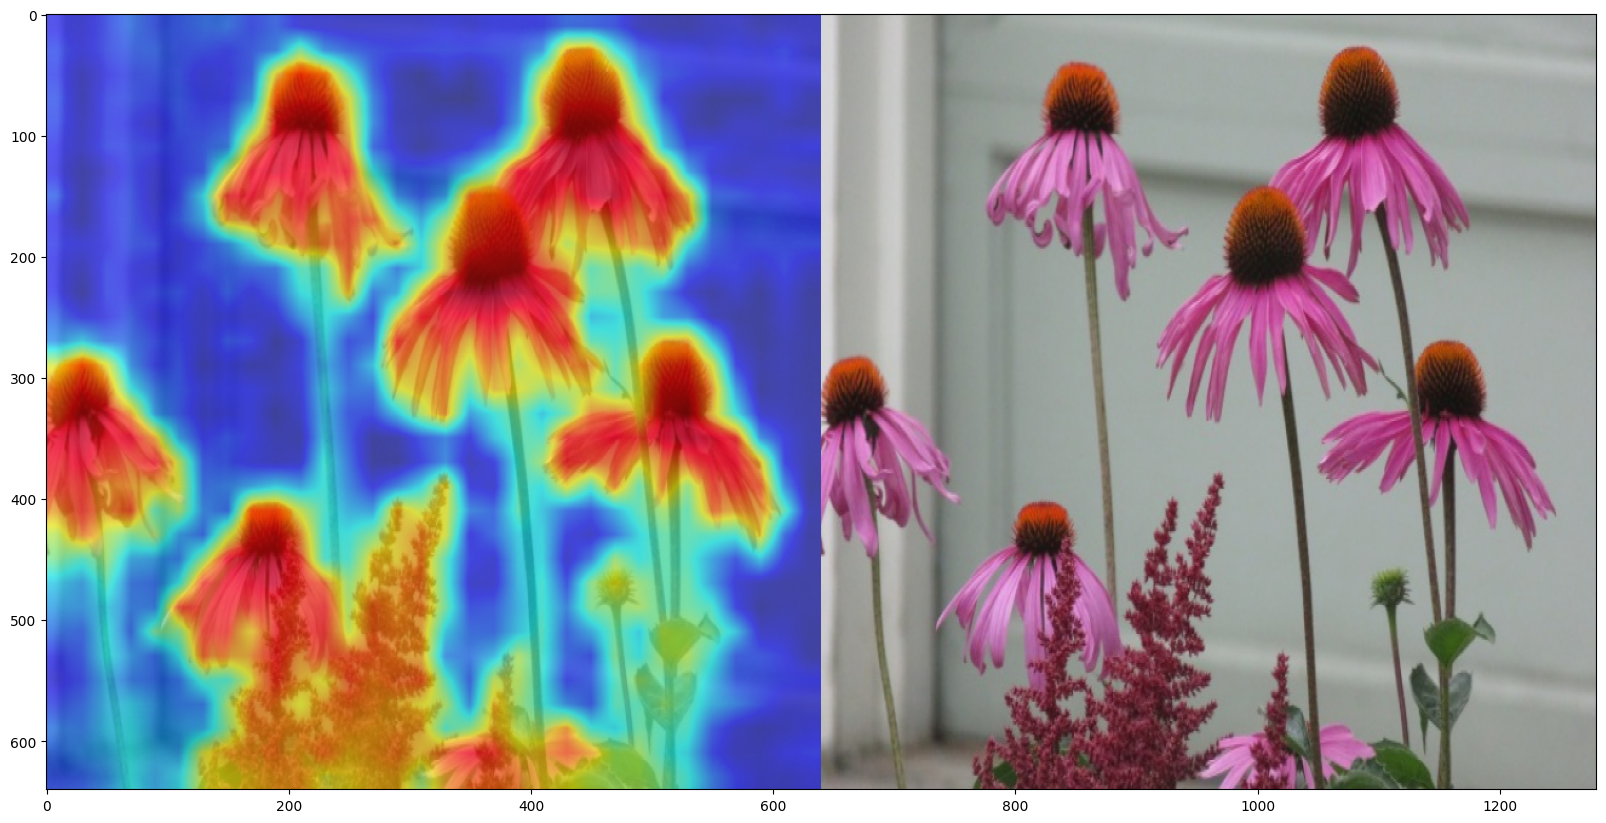

In [9]:
""" Check TransCAM instances """ 
# Read names of the each image
path2img = sorted(glob(os.path.join(voc12_root, "*.jpg")));
img_names = [];
for paths in path2img:
  img_name = paths.split('/')[-1].split('.')[0];
  img_names.append(img_name);


img_label_1 = 4
img_name_1 = img_names[120]
visualize_img('coneflower143', img_label_1) # tomato415 16102

In [10]:
""" Functions to Get instances from semantics """
from skimage.morphology import convex_hull_image
def get_mask(name, label):
    img_path = get_img_path(name)
    orig_img = np.asarray(Image.open(img_path))
    orig_img_size = orig_img.shape[:2]
    img = transform(Image.open(img_path))
    _, _, cams = model('transcam', img.unsqueeze(0).to(device))
    cams = F.interpolate(cams, orig_img_size, mode='bilinear', align_corners=False).detach()
    cams = cams.cpu().numpy()[0][1:]
    cams[cams < 0] = 0
    cam_max = np.max(cams, (1, 2), keepdims=True)
    cam_min = np.min(cams, (1, 2), keepdims=True)
    norm_cam = (cams - cam_min) / (cam_max - cam_min + 1e-5)
    cam = norm_cam[label]
    # cam = cam>0.5;
    pseudo_mask = np.uint8((cam) * 255)
    _, pseudo_mask = cv2.threshold(pseudo_mask,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return orig_img, pseudo_mask

#####################
def iou_define(bounding_box):

  # Search crossed boxes
  bounding_box_copy = bounding_box.copy();
  crossed_box = [];
  count1 = 0;
  for bb1 in bounding_box:
    count2 = count1+1;
    bounding_box_copy.pop(0)
    for bb2 in bounding_box_copy:
      # Define IoU
      x1 = bb1[0];
      x2 = bb1[0]+bb1[2];
      x3 = bb2[0];
      x4 = bb2[0]+bb2[2];

      y1 = bb1[1];
      y2 = bb1[1]+bb1[3];
      y3 = bb2[1];
      y4 = bb2[1]+bb2[3];

      x1_inter = max(x1,x3);
      x2_inter = min(x2,x4);
      y1_inter = min(y2,y4);
      y2_inter = max(y1,y3);

      if( (y1_inter-y2_inter)<=0 or (x2_inter-x1_inter)<=0):
        iou=0.0;
      else:
        interArea = (y1_inter-y2_inter)*(x2_inter-x1_inter);
        boxAArea = (y4 - y3) * (x4 - x3)
        boxBArea = (y2 - y1) * (x2 - x1)
        iou = interArea / float(boxAArea + boxBArea - abs(interArea))
      
      if(iou>0.0):
        crossed_box.append([count1, count2])

      count2=count2+1;
    count1 = count1+1;

  crossed_idx = set();
  for i in crossed_box:
    for j in i:
        crossed_idx.add(j);

  return crossed_box, crossed_idx

##############


def divide_box(mask, bounding_box, bb_cross, bb_not_cross, name, midas, transform_md):

  input_batch = transform_md(img).to(device)
  with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

  output = prediction.cpu().numpy()

  counter1 = 0;
  new_mask = np.uint8(np.zeros((mask.shape)))
  image_bbox = [];
  for i in bb_not_cross:
    counter1 = counter1+1;
    bb1 = bounding_box[i];
    x1 = bb1[0];
    x2 = bb1[0]+bb1[2];
    y1 = bb1[1];
    y2 = bb1[1]+bb1[3];
    box_mask_crop = mask[y1:y2, x1:x2].copy()
    new_mask[y1:y2, x1:x2] = np.bitwise_and(box_mask_crop, counter1);
    image_bbox.append([bb1[0], bb1[1], bb1[2], bb1[3]])

  counter2 = len(bb_not_cross)+2;
  for i in bb_cross:

    # Define IoU
    bb1 = bounding_box[i[0]];
    bb2 = bounding_box[i[1]];

    x1 = bb1[0];
    x2 = bb1[0]+bb1[2];
    x3 = bb2[0];
    x4 = bb2[0]+bb2[2];

    y1 = bb1[1];
    y2 = bb1[1]+bb1[3];
    y3 = bb2[1];
    y4 = bb2[1]+bb2[3];

    x1_inter = max(x1,x3);
    x2_inter = min(x2,x4);
    y1_inter = min(y2,y4);
    y2_inter = max(y1,y3);

    # Crop instances from intersected boxes
    double_box = [min(x1,x3), max(y2,y4), max(x2,x4), min(y1,y3)];

    first_box_midas_crop = output[y1:y2, x1:x2].copy()
    second_box_midas_crop = output[y3:y4, x3:x4].copy()
    intersect_box_midas_crop = output[y2_inter:y1_inter, x1_inter:x2_inter].copy()

    first_box_mask_crop = mask[y1:y2, x1:x2].copy()
    second_box_mask_crop = mask[y3:y4, x3:x4].copy()
    intersect_box_mask_crop = mask[y2_inter:y1_inter, x1_inter:x2_inter].copy()

    first_depth = np.mean(first_box_midas_crop[first_box_mask_crop==255])
    second_depth = np.mean(second_box_midas_crop[second_box_mask_crop==255])
    intersect_depth = np.mean(intersect_box_midas_crop[intersect_box_mask_crop==255])

    # Nan remover
    if(np.isnan(first_depth)):
      first_depth=0.0;
    if(np.isnan(second_depth)):
      second_depth=0.0;
    if(np.isnan(intersect_depth)):
      intersect_depth=0.0;

    if( abs(first_depth-intersect_depth)<abs(second_depth-intersect_depth) ):
      new_mask[y3:y4, x3:x4] = np.bitwise_and( second_box_mask_crop, counter2-1);
      new_mask[y1:y2, x1:x2] = np.bitwise_and(first_box_mask_crop, counter2); 
      image_bbox.append([bb2[0], bb2[1], bb2[2], bb2[3]]);
      image_bbox.append([bb1[0], bb1[1], bb1[2], bb1[3]]);
    else:
      new_mask[y1:y2, x1:x2] = np.bitwise_and(first_box_mask_crop, counter2-1); 
      new_mask[y3:y4, x3:x4] = np.bitwise_and(second_box_mask_crop, counter2);
      image_bbox.append([bb1[0], bb1[1], bb1[2], bb1[3]]);
      image_bbox.append([bb2[0], bb2[1], bb2[2], bb2[3]]);
    counter2 = counter2+2;

  new_mask[new_mask==255] =0;
  new_mask_bad = np.uint8( new_mask*np.round(255.0/(len(bb_full)+1)) );
  new_mask = np.uint8( new_mask );
  # new_mask_heat = cv2.applyColorMap(new_mask_bad, cv2.COLORMAP_JET)
  # new_mask_heat = cv2.cvtColor(new_mask_heat, cv2.COLOR_BGR2RGB)
  new_mask_heat = cv2.cvtColor(new_mask_bad,cv2.COLOR_BGR2RGB)

  return new_mask_heat, new_mask, image_bbox



# Extract image annotations
def get_dataset_ann(path2ann):
  ann_in_img = [];
  hw_in_img = [];
  for ann in path2ann:
    with open(ann) as file:
        data = json.load(file)

        h = data['size']['height'];
        w = data['size']['width'];
        objects = data['objects'];

        # define amount of the part instances in the image
        plant_instance = set();
        for part in objects:
          plant_instance.add(part['classTitle'])
        
        # extract bit map for each instance
        plant_data = {};
        for instance in plant_instance:
          plant_data[instance] = [];
          # plant_data[instance] = {'bitmap': []};
          for part in objects:
            if( part['tags']!=[] ):
              if(instance == part['classTitle']):
                plant_data[instance].append( part['bitmap'])
        
        ann_in_img.append(plant_data)
        hw_in_img.append([h,w])
  return ann_in_img, hw_in_img;


# Function to find polygons and boxes coord
h2 = 640;
w2 = 640;
def get_poly_and_box(ann_in_img, hw_in_img):

  thresh = 1;
  counter = 0;
  all_poly_in_img = []
  all_bbox_in_img = []
  for ann in tqdm(ann_in_img):
    h = hw_in_img[counter][0];
    w = hw_in_img[counter][1];
    poly_in_class = {};
    bbox_in_class = {};


    for class_name in ann.keys():
      image_polygons = [];
      image_bbox = [];

      for class_bitmap in ann[class_name]:

        # CONTOURS EXTRACTION
        contours, _ = cv2.findContours(cv2.resize( np.bitwise_and( rleToMask(get_rle_mask(class_bitmap, h, w), w, h) , 255) , (h2,h2), interpolation = cv2.INTER_AREA),
                                       cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        polygons = []
        coords = [];
        for contour in contours:
          for i in [contour]:
            for j in i:
              coords.append(j)
              polygons.append(float(j[0][0]));
              polygons.append(float(j[0][1]));

        # x_cord = polygons[0::2];
        # y_cord = polygons[1::2];
        bx,by,bw,bh = cv2.boundingRect(np.array(coords));

        image_polygons.append( [polygons] );
        image_bbox.append([bx,by,bw,bh]);
        del coords
        del polygons
        del contours

      poly_in_class[class_name] = image_polygons;
      bbox_in_class[class_name] = image_bbox

    all_poly_in_img.append( poly_in_class )
    all_bbox_in_img.append( bbox_in_class );
    counter = counter + 1;

  return all_poly_in_img, all_bbox_in_img

def get_pseudo_poly_and_box(new_mask):
  # One hot encoding for each object in the image
  n_classes = len(np.unique(new_mask))-1;
  one_hot = np.zeros((new_mask.shape[0], new_mask.shape[1], n_classes))
  for i, unique_value in enumerate(np.unique(new_mask)[1:]):
      one_hot[:, :, i][new_mask == unique_value] = 1;
      # one_hot[:, :, i] = convex_hull_image(one_hot[:, :, i]);
  one_hot = np.uint8(one_hot);

  # Get polygons
  thresh = 0;
  image_polygons = [];
  image_bbox = [];
  for class_num in range(n_classes):
    # ret,thresh_img = cv2.threshold( np.uint8(convex_hull_image(one_hot[:,:,class_num])), thresh, 255, cv2.THRESH_BINARY)
    ret,thresh_img = cv2.threshold( one_hot[:,:,class_num], thresh, 255, cv2.THRESH_BINARY)
    # contours, _ = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    clen = [];
    for con in contours:
      clen.append(con.shape[0])
    max_val = max(clen);
    max_ind = clen. index (max_val);

    polygons = []
    contours = [contours[max_ind]]
    x,y,w,h = cv2.boundingRect(contours[0]);
    for i in contours:
      coords = [];
      for j in i:
        coords.append( float(j[0][0]) );
        coords.append( float(j[0][1]) );
      polygons.append(coords)
    # polygons = []
    # coords = [];
    # for contour in contours:
    #   for i in [contour]:
    #     for j in i:
    #       coords.append(j)
    #       polygons.append(float(j[0][0]));
    #       polygons.append(float(j[0][1]));

    # x_cord = polygons[0::2];
    # y_cord = polygons[1::2];
    # x,y,w,h = cv2.boundingRect(np.array(coords));

    image_polygons.append(polygons);
    image_bbox.append([x,y,w,h]);

  return image_polygons, image_bbox, one_hot

# Transform and write train annotations into YOLOv8 format

In [11]:
# Extract train images annotations
path2img = sorted(glob(os.path.join('../dataset_yolo/images/train', "*.jpg")));
IMG_FOLDER_NAME = voc12_root;
img_names = [];
for paths in path2img:
  img_name = paths.split('/')[-1].split('.')[0];
  img_names.append(img_name);

path2ann = sorted(glob(os.path.join('../dataset_yolo/labels_json/train/','*.json')))
ann_in_img, hw_in_img = get_dataset_ann(path2ann);

# Find polygons and boxes for annotation
all_poly_in_img, all_bbox_in_img = get_poly_and_box(ann_in_img, hw_in_img);

100%|██████████| 358/358 [05:49<00:00,  1.02it/s]


 68%|██████▊   | 244/358 [00:00<00:00, 85022.03it/s]


allium321


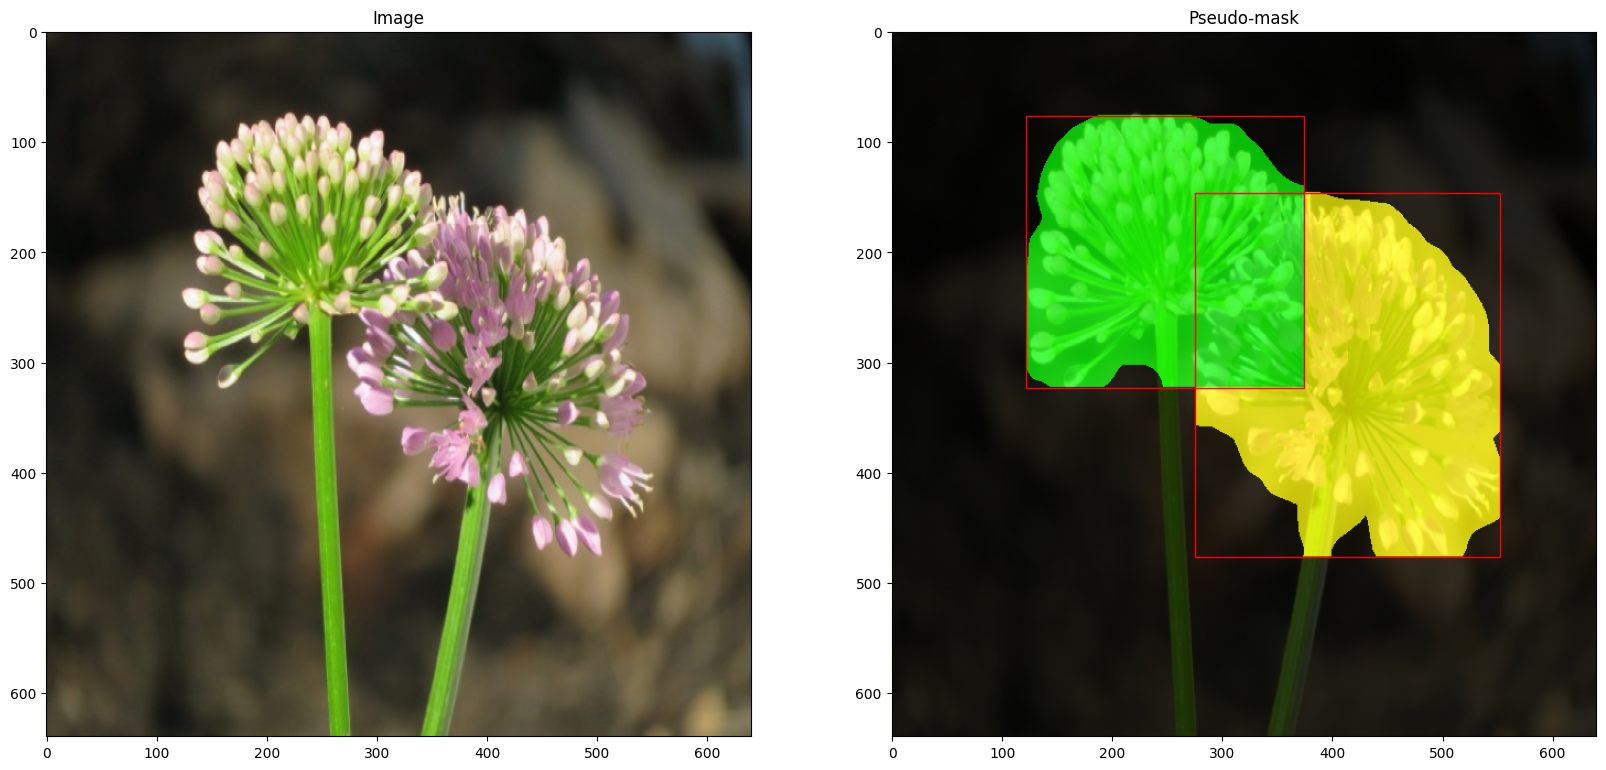

In [13]:
""" Check pseudo-instance inference """

check_name = 'allium321'

# Get mask
counter = 0;
for img_name in tqdm(img_names, total=len(img_names)):
  if(img_name == check_name):
    print(img_name)
    break;
  else:
  
    counter = counter + 1;

counter = 0;
for bbox_in_img in all_bbox_in_img:

  if(img_names[counter] == check_name):
    bb_full = bbox_in_img['flower'];
    break;
  else:
    counter=counter+1;


# Got crossed and boxes
bb_cross, bb_idx = iou_define(bb_full)

bb_not_cross = [];
for i in range(len(bb_full)):
  if(i not in bb_idx):
    bb_not_cross.append(i);

# Find inctance map
img, mask = get_mask(img_name, 4) 
new_mask_heat, new_mask,_ = divide_box(mask, bb_full, bb_cross, bb_not_cross, img_name, midas, transform_md)

## Instance Mask
import random
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]];
instance_mask = new_mask_heat.copy();
for inst in np.unique(new_mask)[1:]:
  instance_mask[new_mask==inst] = colours[random.randrange(0,10)]
instance_mask_transparent = cv2.addWeighted(instance_mask, 0.7, img, 0.3, 0.0);

# Plot images
plt.figure(2, figsize=(20,20))
plt.subplot(121)
plt.imshow(img)
plt.title('Image')

plt.subplot(122)
plt.imshow(instance_mask_transparent)
for i in range(len(bb_full)):
  B = bb_full[i];
  plt.gca().add_patch(Rectangle((B[0],B[1]),B[2],B[3], edgecolor='red', facecolor='none', lw=1))
plt.title('Pseudo-mask')
plt.show()


In [14]:
# Dict of the classes
object_type = {"background": 0,
              "stem": 1,  
              "leaf": 2, 
              "fruit": 3,
              "flower": 4,
              "root": 5,
              "other": 6}

In [15]:
""" GET YOLO ANNOTATIONS |REFERENCE TRAIN BOX| """
if(flag=='bbox'):

  counter = 0;

  for bbox_in_img in tqdm(all_bbox_in_img):
    img_name = img_names[counter];
    IMG_FOLDER_NAME = '../dataset_yolo/images/train';
    lines = [];
    bb_full = [];
    for class_in_img in bbox_in_img.keys():

      # Get mask
      class_num = object_type[class_in_img.lower()]
      img, mask = get_mask(img_name, class_num) 
      H = img.shape[0];
      W = img.shape[1];

      # Extract class bbox
      test_bbox = bbox_in_img[class_in_img];

      # Collect annotations
      for bbox in test_bbox:

        xn = bbox[0]/float(W);
        yn = bbox[1]/float(H);
        wn = bbox[2]/float(W);
        hn = bbox[3]/float(H);

        line = str(class_num)+' '+str(xn)+' '+str(yn)+' '+str(xn+wn)+' '+str(yn)+' '+str(xn+wn)+' '+str(yn+hn)+' '+str(xn)+' '+str(yn+hn)+' '+str(xn)+' '+str(yn)+'\n';

        lines.append(line);
        bbox_list = [];
        line = '';

    # write labels
    with open('../dataset_yolo/labels/train/' + img_name + '.txt', 'w') as f:
      for stroka in lines:
        f.write(stroka);

    counter = counter + 1;


In [ ]:
""" GET YOLO ANNOTATIONS |PSEUDO TRAIN POLYGONS| """

if(flag=='pseudo'):

  counter = 0;

  for bbox_in_img in tqdm(all_bbox_in_img):
    img_name = img_names[counter];
    lines = [];
    bb_full = [];
    for class_in_img in bbox_in_img.keys():

      # Get mask
      class_num = object_type[class_in_img.lower()]; ###+3
      img, mask = get_mask(img_name, class_num);
      H = img.shape[0];
      W = img.shape[1];

      # Extract class bbox
      bb_full = bbox_in_img[class_in_img];

      # Got crossed and dont crossed boxes
      bb_cross, bb_idx = iou_define(bb_full)

      bb_not_cross = [];
      for i in range(len(bb_full)):
        if(i not in bb_idx):
          bb_not_cross.append(i);

      # Find inctance map
      new_mask_heat, new_mask,_ = divide_box(mask, bb_full, bb_cross, bb_not_cross, img_name, midas, transform_md)

      # Find polygons and boxes for annotation
      test_poly, test_bb,_ = get_pseudo_poly_and_box(new_mask);

      # Collect annotations
      for i in range(len(test_poly)):
        poly_list = test_poly[i][0].copy();
        # print(len(poly_list), img_name)
        if(len(poly_list)<6):
          None;
        else:
          poly_x = [ii/float(W) for ii in poly_list[0::2]];
          poly_y = [jj/float(H) for jj in poly_list[1::2]];
          poly_list[0::2] = poly_x.copy()
          poly_list[1::2] = poly_y.copy()

          line = str(class_num);  #str(class_num-1);
          for sym in poly_list:
            line = line + ' ' + str(sym);
          line = line + '\n';
          
          lines.append(line);
          poly_list = [];
          line = '';

    # write labels
    with open('../dataset_yolo/labels/train/' + img_name + '.txt', 'w') as f:
      for stroka in lines:
        f.write(stroka);

    counter = counter + 1;



In [ ]:
""" GET YOLO ANNOTATIONS |REFERENCE TRAIN POLYGONS| """
if(flag=='gt'):
  
  counter = 0;

  for poly_in_img in tqdm(all_poly_in_img):
    img_name = img_names[counter];
    IMG_FOLDER_NAME = '../dataset_yolo/images/train';
    lines = [];
    bb_full = [];
    for class_in_img in poly_in_img.keys():

      # Get mask
      class_num = object_type[class_in_img.lower()]
      img, mask = get_mask(img_name, class_num) 
      H = img.shape[0];
      W = img.shape[1];

      # Extract class bbox
      test_poly = poly_in_img[class_in_img];

      # Collect annotations
      for i in range(len(test_poly)):
        poly_list = test_poly[i][0].copy();
        if(len(poly_list)<6):
          None;
        else:
          poly_x = [ii/float(W) for ii in poly_list[0::2]];
          poly_y = [jj/float(H) for jj in poly_list[1::2]];
          poly_list[0::2] = poly_x.copy()
          poly_list[1::2] = poly_y.copy()

          line = str(class_num);
          for sym in poly_list:
            line = line + ' ' + str(sym);
          line = line + '\n';
          
          lines.append(line);
          poly_list = [];
          line = '';

    # write labels
    with open('../dataset_yolo/labels/train/' + img_name + '.txt', 'w') as f:
      for stroka in lines:
        f.write(stroka);

    counter = counter + 1;


# Transform and write test annotations into YOLOv8 format

In [16]:
# Extract test images annotations
path2img = sorted(glob(os.path.join('../dataset_yolo/images/test', "*.jpg")));
img_names = [];
for paths in path2img:
  img_name = paths.split('/')[-1].split('.')[0];
  img_names.append(img_name);

# Extract annotations
path2ann = sorted(glob(os.path.join('../dataset_yolo/labels_json/test/','*.json')))
ann_in_img, hw_in_img = get_dataset_ann(path2ann);

# Find reference polygons and boxes for annotation
all_poly_in_img, all_bbox_in_img = get_poly_and_box(ann_in_img, hw_in_img);


100%|██████████| 156/156 [02:40<00:00,  1.03s/it]


In [20]:
""" GET YOLO ANNOTATIONS |REFERENCE POLYGONS| """

# Part classes
object_type = {"background": 0,
              "stem": 1,  
              "leaf": 2, 
              "fruit": 3,
              "flower": 4,
              "root": 5,
              "other": 6}


counter = 0;
bb_full = [];

for poly_in_img in tqdm(all_poly_in_img):
  img_name = img_names[counter];
  IMG_FOLDER_NAME = '../dataset_yolo/images/test';
  lines = [];
  bb_full = [];
  for class_in_img in poly_in_img.keys():

    # Get mask
    class_num = object_type[class_in_img.lower()]
    img, mask = get_mask(img_name, class_num) 
    H = img.shape[0];
    W = img.shape[1];

    # Extract class bbox
    test_poly = poly_in_img[class_in_img];

    # Collect annotations
    for i in range(len(test_poly)):
      poly_list = test_poly[i][0].copy();
      if(len(poly_list)<6):
        None;
      else:
        poly_x = [ii/float(W) for ii in poly_list[0::2]];
        poly_y = [jj/float(H) for jj in poly_list[1::2]];
        poly_list[0::2] = poly_x.copy()
        poly_list[1::2] = poly_y.copy()

        line = str(class_num);
        for sym in poly_list:
          line = line + ' ' + str(sym);
        line = line + '\n';
        
        lines.append(line);
        poly_list = [];
        line = '';


  # write labels
  with open('../dataset_yolo/labels/test/' + img_name + '.txt', 'w') as f:
    for stroka in lines:
      f.write(stroka);

  counter = counter + 1;




